<a href="https://colab.research.google.com/github/DavideMugi/ProgettoMachineLearning/blob/master/AC_T1D_CCEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Just cloning a repository in which it's possible to find the exact code for tile coding by Sutton:

In [ ]:
!git clone https://github.com/kamenbliznashki/sutton_barto

Cloning into 'sutton_barto'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 3.61 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (5/5), done.


Installing the Type-1 Diabetes simulator (**remember to restart the runtime at the end of the installation!**):

In [ ]:
!pip install simglucose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.8/157.8 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.3 MB/s eta 0:0

The actual AC RL agent implementation:



In [ ]:
from simglucose.simulation.user_interface import simulate
from simglucose.controller.base import Controller, Action
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
import numpy as np
import math
import itertools
from datetime import datetime, timedelta
from sutton_barto import tiles3


import pandas as pd
import pkg_resources

SENSOR_PARA_FILE = pkg_resources.resource_filename(
    'simglucose', 'params/sensor_params.csv')
PUMP_PARA_FILE = pkg_resources.resource_filename(
    'simglucose', 'params/pump_params.csv')

class MyController(Controller):
    def __init__(self, my_sim_timedelta, timedelta_window, h, KS, a_h, a_l, epsilon, tilings_number, tiles_number_ax , my_sensor, my_pump):
        self.my_sensor=my_sensor
        self.my_pump=my_pump
        self.sensor_params = pd.read_csv(SENSOR_PARA_FILE)
        self.pump_params = pd.read_csv(PUMP_PARA_FILE)
        self.my_sim_timedelta=my_sim_timedelta
        self.my_sim_time = self.my_sim_timedelta.total_seconds() / 60 #obtaining  the number of minutes from the timedelta object specifying the simulation duration
        self.timedelta_window=timedelta_window
        self.time_window = self.timedelta_window.total_seconds() / 60
        self.windows=math.ceil(self.my_sim_time/self.time_window)
        self.k=4 #dimension of the state, fixed
        self.h_samples=[0]*(self.windows+1) #counts how many times in each time window the patient stays in the hyperglycemia zone
        self.l_samples=[0]*(self.windows+1) #counts how many times in each time window the patient stays in the hypoglycemia zone
        self.x=[[0]*self.k for _ in range(self.windows+1)] #this will be the state space, for each time window

        self.temp_1=[0]*(self.windows+1)
        self.temp_2=[0]*(self.windows+1)


        self.theta_BR=[[0]*self.k for _ in range(self.windows+1)]
        self.theta_IC=[[0]*self.k for _ in range(self.windows+1)]
        self.t=0

        self.average_reward_BR=[0]*(self.windows+1)
        self.average_reward_IC=[0]*(self.windows+1)

        self.delta_BR=[0]*(self.windows+1)
        self.delta_IC=[0]*(self.windows+1)



        #set of parameters I'll use later on
        self.h=h
        self.KS=KS
        self.a_h=a_h
        self.a_l=a_l
        self.epsilon=epsilon



        self.tilings_number = tilings_number #16
        self.tiles_number_ax = tiles_number_ax #10
        if self.tilings_number < 4*self.k and self.tilings_number%2 != 0:
         raise ValueError("The number of tilings needs to be a power of two and greater than four times the state space dimension.")
        #square tilings
        self.scaleFactor = self.tiles_number_ax/1 #1 is the width of a single dimension of the state space, and we assume it is a squared state space
        if ((self.tiles_number_ax+1)**self.k)*self.tilings_number <= 2**13: #2^13 is 8192
          self.tiles_number = ((self.tiles_number_ax+1)**self.k)*self.tilings_number
        else:
          self.tiles_number = 2**13
        self.N=self.tiles_number
        self.iht=tiles3.IHT(self.N)

        self.alpha_feature = 0.1/self.tilings_number

        self.w_BR=[[0]*self.N for _ in range(self.windows+1)] #initialization
        self.w_IC=[[0]*self.N for _ in range(self.windows+1)] #initialization

        self.z_w_BR=[[0]*self.N for _ in range(self.windows+1)]
        self.z_w_IC=[[0]*self.N for _ in range(self.windows+1)]
        self.z_theta_BR=[[0]*self.k for _ in range(self.windows+1)]
        self.z_theta_IC=[[0]*self.k for _ in range(self.windows+1)]

        self.alpha_R=2.5e-1
        self.alpha_w=1e-1
        #self.alpha_theta=5e-2

        self.lambda_w=0.2
        self.lambda_theta=0.1


        self.BR= 6e-2
        self.IC= 6e-2

        self.rate_BR=[0]*(self.windows+1)
        self.rate_IC=[0]*(self.windows+1)

        self.u_BR=[0]*(self.windows+1)
        self.u_IC=[0]*(self.windows+1)
        self.P_d_BR=[0]*(self.windows+1)
        self.P_d_IC=[0]*(self.windows+1)
        self.sigma_BR=[self.epsilon**0.5]*(self.windows+1)
        self.sigma_IC=[self.epsilon**0.5]*(self.windows+1)




        for i in range(self.sensor_params.shape[0]):
          if self.sensor_params.loc[i, 'Name'] == self.my_sensor:
            row_label=i
        self.max_G=self.sensor_params.loc[row_label, 'max']
        self.min_G=self.sensor_params.loc[row_label, 'min']
        print(f"Range of the CGM: [{self.min_G}, {self.max_G}]")

        for i in range(self.pump_params.shape[0]):
          if self.pump_params.loc[i, 'Name'] == self.my_pump:
            row_label=i
        self.max_basal=self.pump_params.loc[row_label, 'max_basal']
        self.min_basal=self.pump_params.loc[row_label, 'min_basal']
        self.max_bolus=self.pump_params.loc[row_label, 'max_bolus']
        self.min_bolus=self.pump_params.loc[row_label, 'min_bolus']
        print(f"Basal range of the pump: [{self.min_basal}, {self.max_basal}]")
        print(f"Bolus range of the pump: [{self.min_bolus}, {self.max_bolus}]")


    def feature_transformation(self, x):
        scaled_x = [entry * self.scaleFactor for entry in x]
        f_indices_tiles = tiles3.tiles(self.iht, self.tilings_number, scaled_x)
        self.iht.fullp()
        return f_indices_tiles


    def dot_product(self, A, B):
        if len(A) != len(B):
          raise ValueError("Lists A and B must have the same length")
        result = 0
        for i in range(len(A)):
          result += A[i] * B[i]
        return result


    def value_function(self, f, w):
        v=0 #initialization
        for j in f:
          v += w[j]
        return v


    def deterministic_BR_control_action(self, x, theta):
        #linear deterministic control action
        P_a=self.dot_product(x, theta)
        #supervisory control action
        if (x[0]==0) and (x[2]==0):
          P_s=0
        if (x[0]>0) and (x[2]==0):
          P_s=0.1*x[0]
        if (x[2]>0):
          P_s=-0.1*x[2]
        #total deterministic control action
        P_d=self.h*P_a+(1-self.h)*P_s
        return P_d


    def deterministic_IC_control_action(self, x, theta):
        #linear deterministic control action
        P_a=self.dot_product(x, theta)
        #supervisory control action
        if (x[0]==0) and (x[2]==0):
          P_s=0
        if (x[0]>0) and (x[2]==0):
          P_s=-0.1*x[0]
        if (x[2]>0):
          P_s=+0.1*x[2]
        #total deterministic control action
        P_d=self.h*P_a+(1-self.h)*P_s
        return P_d

    def exploratory_sigma(self, x):
        if self.KS*(x[1]**2+x[3]**2)>self.epsilon:
          sigma_square=self.KS*(x[1]**2+x[3]**2)
        else:
          sigma_square = self.epsilon
        sigma=sigma_square**0.5
        return sigma


    def policy_action(self, x, P_d):
        #self.dot_product(x, x)
        #just a way to ensure the parameter sigma is different from zero
        sigma=self.exploratory_sigma(x)
        #exploratory control action
        control_action = np.random.normal(P_d, sigma)
        return control_action, sigma

    def reward_function(self, x):
        r=(self.a_h+self.a_l)*(1-x[1]-x[3])-(self.a_h*x[0]+self.a_l*x[2])
        #r = (24*self.a_h/(23*6))*(1-x[1]-x[3])-(self.a_h*x[0]+self.a_l*x[2])
        return r

    def TD_error(self, x, i, average_reward, w):
        f1=self.feature_transformation(x[i])
        f0=self.feature_transformation(x[i-1])

        delta=self.reward_function(x[i])-average_reward[i-1]+self.value_function(f1, w[i-1])-self.value_function(f0, w[i-1])
        return delta


    def average_reward_update(self, average_reward, i, delta):
        a=average_reward[i-1]+self.alpha_R*delta[i]
        return a


    def critic_ET_update(self, x, z_w, i):
        f_indices_tiles = self.feature_transformation(x[i-1])
        c=self.iht.count()
        for j in range(c):
          z_w[i][j] = self.lambda_w*z_w[i-1][j]
        for indices in f_indices_tiles:
          z_w[i][indices] += 1

    def actor_ET_update(self, x, z_theta, i, P_d, sigma, u):
        psi=[]
        for j in range(self.k):
          psi.append(((u[i-1]-P_d[i-1])/(sigma[i-1])**2)*self.h*x[i-1][j])
        temp=[entry * (self.lambda_theta) for entry in z_theta[i-1]]
        z_theta=[a + b for a, b in zip(temp, psi)]
        return z_theta


    def critic_update(self, z_w, delta, w, i):
        c = self.iht.count()
        for j in range(c):
          w[i][j]=w[i-1][j]+self.alpha_feature*delta[i]*z_w[i][j]


    def actor_update(self, z_theta, delta, theta, i, x):
        sigma=self.exploratory_sigma(x[i])
        temp=[entry * ((sigma**2)*delta[i]) for entry in z_theta[i]]
        theta=[a + b for a, b in zip(theta[i-1], temp)]
        return theta



    def policy(self, observation, reward, done, **kwargs):

        sample_time = kwargs.get('sample_time')  # Returns None if key not present, it seems implicitly defined as 3 minutes, sample time of the sensor
         #(which is different from the one of the insulin pump)
        if sample_time is None:
          raise ValueError("The 'sample_time' keyword argument is required.")
        meal = kwargs.get('meal')
        if meal is None:
          raise ValueError("The 'meal' keyword argument is required.")


        if self.t == 0:
          print(f"Starting with:\nBR={self.BR}, IC={self.IC}.")

        G = observation.CGM
        self.t += sample_time

        i=math.ceil(self.t/self.time_window)
        open_loop_period=1

        G_h=180
        G_l=70

        if G > G_h:
            self.h_samples[i] += 1
            self.temp_1[i] += G-G_h

            self.x[i][0]=(self.temp_1[i]/(self.h_samples[i]*(self.max_G-G_h))) #STATE COMPONENT 1: normalized hyperglycemia error
            self.x[i][1]=self.h_samples[i]/(self.time_window/sample_time) #STATE COMPONENT 2: normalized time spent in hyperglycemia

        if G < G_l:
            self.l_samples[i] += 1
            self.temp_2[i] += G_l-G

            self.x[i][2]=(self.temp_2[i]/(self.l_samples[i]*(G_l-self.min_G))) #STATE COMPONENT 3: normalized hypoglycemia error
            self.x[i][3]=self.l_samples[i]/(self.time_window/sample_time) #STATE COMPONENT 4: normalized time spent in hypoglycemia

        if (self.t%self.time_window==0) and i<=open_loop_period:

          green_code="\033[32m"
          red_code = "\033[91m"  # ANSI escape code for red text
          reset_code = "\033[0m"   # ANSI escape code to reset color
          print(f"\n{red_code}Reward at the end of the day {i}: {self.reward_function(self.x[i])}{reset_code}")
          print(f"{green_code}State of the day {i}: {self.x[i]}{reset_code}")

          self.P_d_BR[i]=self.deterministic_BR_control_action(self.x[i], self.theta_BR[i])
          self.P_d_IC[i]=self.deterministic_IC_control_action(self.x[i], self.theta_IC[i])

          [self.u_BR[i], self.sigma_BR[i]]=self.policy_action(self.x[i], self.P_d_BR[i])
          [self.u_IC[i], self.sigma_IC[i]]=self.policy_action(self.x[i], self.P_d_IC[i])


          self.BR=self.BR+(self.u_BR[i])*self.BR
          self.IC=self.IC+(self.u_IC[i])*self.IC

          print(f"Entering the {i+1}-th day with:\nBR={self.BR}, IC={self.IC}.")


        if (self.t%self.time_window==0) and open_loop_period < i <(self.windows):

          green_code="\033[32m"
          red_code = "\033[91m"  # ANSI escape code for red text
          reset_code = "\033[0m"   # ANSI escape code to reset color
          print(f"\n{red_code}Reward at the end of the day {i}: {self.reward_function(self.x[i])}{reset_code}")
          print(f"{green_code}State of the day {i}: {self.x[i]}{reset_code}")

          print("Only parameter referring to BR will be printed for the sake of clarity.")
          f1=self.feature_transformation(self.x[i])
          f0=self.feature_transformation(self.x[i-1])
          print(f"Transformed feacture vector_{i}={f1}")
          print(f"Transformed feacture vector_{i-1}={f0}")
          print(f"Value function V_1={self.value_function(f1, self.w_BR[i-1] )}")
          print(f"Value function V_0={self.value_function(f0, self.w_BR[i-1] )}")


          self.delta_BR[i]=self.TD_error(self.x, i, self.average_reward_BR, self.w_BR)
          self.delta_IC[i]=self.TD_error(self.x, i, self.average_reward_IC, self.w_IC)
          print(f"TD error d_{i}={self.delta_BR[i]}")

          self.average_reward_BR[i]=self.average_reward_update(self.average_reward_BR, i, self.delta_BR)
          self.average_reward_IC[i]=self.average_reward_update(self.average_reward_IC, i, self.delta_IC)
          print(f"Average reward R_{i}={self.average_reward_BR[i]}")

          self.critic_ET_update(self.x, self.z_w_BR, i)
          self.critic_ET_update(self.x, self.z_w_IC, i)

          self.z_theta_BR[i]=self.actor_ET_update(self.x, self.z_theta_BR, i, self.P_d_BR, self.sigma_BR, self.u_BR)
          self.z_theta_IC[i]=self.actor_ET_update(self.x, self.z_theta_IC, i, self.P_d_IC, self.sigma_IC, self.u_IC)
          print(f"Eligibility trace z_theta_{i}={self.z_theta_BR[i]}")

          self.critic_update(self.z_w_BR, self.delta_BR, self.w_BR, i)
          self.critic_update(self.z_w_IC, self.delta_IC, self.w_IC, i)


          self.theta_BR[i]=self.actor_update(self.z_theta_BR, self.delta_BR, self.theta_BR, i, self.x)
          self.theta_IC[i]=self.actor_update(self.z_theta_BR, self.delta_BR, self.theta_BR, i, self.x)
          print(f"Actor parameter theta_{i}=({self.theta_BR[i]})\n")


          self.P_d_BR[i]=self.deterministic_BR_control_action(self.x[i], self.theta_BR[i])
          self.P_d_IC[i]=self.deterministic_IC_control_action(self.x[i], self.theta_IC[i])
          [self.u_BR[i], self.sigma_BR[i]]=self.policy_action(self.x[i], self.P_d_BR[i])
          [self.u_IC[i], self.sigma_IC[i]]=self.policy_action(self.x[i], self.P_d_IC[i])

          self.BR=self.BR+(self.u_BR[i])*self.BR
          self.IC=self.IC+(self.u_IC[i])*self.IC

          print(f"Entering the {i+1}-th day with:\nBR={self.BR}, IC={self.IC}.")


        basal_rate=self.BR
        bolus_rate=(self.IC*meal)/sample_time
        action = Action(basal=basal_rate, bolus=bolus_rate)
        return action


    def reset(self):
        pass

Controller initialization:

In [ ]:
# specify start_time as the beginning of today, or change it manually to change the start time
now = datetime.now()
my_start_time = datetime.combine(now.date(), datetime.min.time())
my_sim_time=timedelta(days=30) #duration of the simulation, it can be changed
my_time_window = timedelta(days=1) #duration of the time window, it can be change
my_sensor='Dexcom' #type of sensor used, it can be changed but there are few options
my_pump='Insulet' #type of insulin pump used, it can be changed but there are few options

my_controller = MyController(my_sim_time, my_time_window, 0.5, 5e-2, 1, 4, (5e-2)/100, 16, 10, my_sensor, my_pump)

Range of the CGM: [39.0, 600.0]
Basal range of the pump: [0.0, 30.0]
Bolus range of the pump: [0.0, 30.0]


Meal scenario definition:

In [ ]:
#deterministic meal scenario by me
meal_scenario=[]
for k in range(my_sim_time.days):
   if 11+24*k < my_sim_time.total_seconds()/3600:
      CHO = 45
      time = 9+24*k
      meal_scenario.append((time, CHO))
   if 16+24*k < my_sim_time.total_seconds()/3600:
      CHO = 85
      time=14.5+24*k
      meal_scenario.append((time, CHO))
   if 22+24*k < my_sim_time.total_seconds()/3600:
      CHO = 90
      time = 21+24*k
      meal_scenario.append((time, CHO))
   if 24+24*k < my_sim_time.total_seconds()/3600:
      CHO = 30
      time = 23.524*k
      meal_scenario.append((time, CHO))

#stochastic meal scenario by Elena Daskalaki
#meal_scenario=[]
#for k in range(my_sim_time.days):
#   if 11+24*k < my_sim_time.total_seconds()/3600:
#      CHO = np.random.uniform(30, 60)
#      time = np.random.uniform(7+24*k, 11+24*k)
#      meal_scenario.append((time, CHO))
#   if 16+24*k < my_sim_time.total_seconds()/3600:
#      CHO = np.random.uniform(70, 100)
#      time=np.random.uniform(13+24*k, 16+24*k)
#      meal_scenario.append((time, CHO))
#   if 22+24*k < my_sim_time.total_seconds()/3600:
#      CHO = np.random.uniform(70, 110)
#      time = np.random.uniform(20+24*k, 22+24*k)
#      meal_scenario.append((time, CHO))
#   if 24+24*k < my_sim_time.total_seconds()/3600:
#      CHO = np.random.uniform(20, 40)
#      time = np.random.uniform(23+24*k, 24+24*k)
#      meal_scenario.append((time, CHO))

my_scenario = CustomScenario(start_time=my_start_time, scenario=meal_scenario)

Start the simulation!

Process ID: 1100
Simulation starts ...
Starting with:
BR=0.06, IC=0.06.

Reward at the end of the day 1: 1.4746536418148428
State of the day 1: [0.0006568403537663752, 0.004166666666666667, 0.4801307127911811, 0.31666666666666665]
Entering the 2-th day with:
BR=0.06334805946820288, IC=0.057297756034092207.

Reward at the end of the day 2: -1.4798434202301642
State of the day 2: [0, 0, 0.7892316883908744, 0.6645833333333333]
Only parameter referring to BR will be printed for the sake of clarity.
Transformed feacture vector_2=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Transformed feacture vector_1=[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Value function V_1=0
Value function V_0=0
TD error d_2=-1.4798434202301642
Average reward R_2=-0.36996085505754106
Eligibility trace z_theta_2=[0.005226654522012387, 0.03315528202580183, 3.8205286060418073, 2.5198014339609385]
Actor parameter theta_2=([-0.00017080809774031058, -0.0010835211374732793, -0.124855626254245

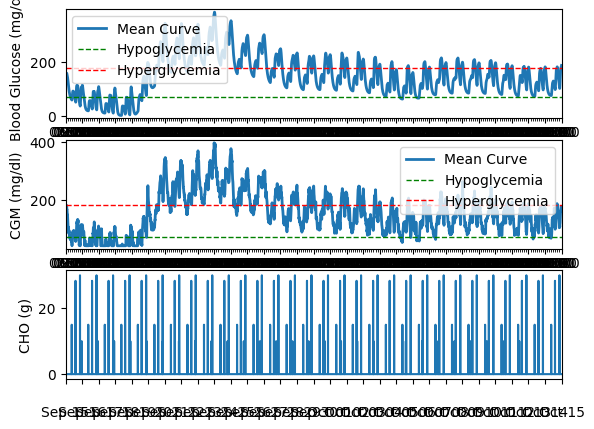

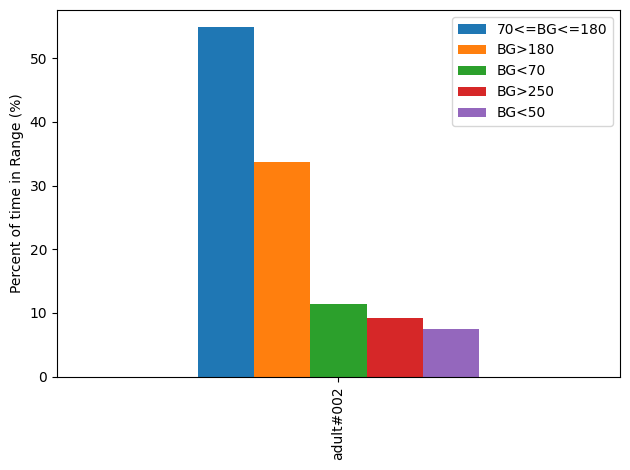

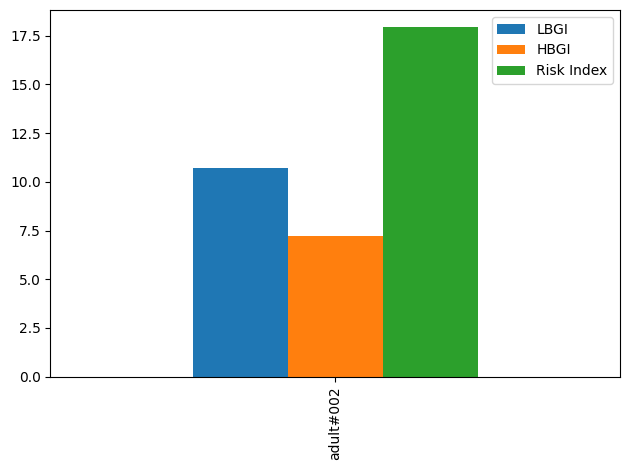

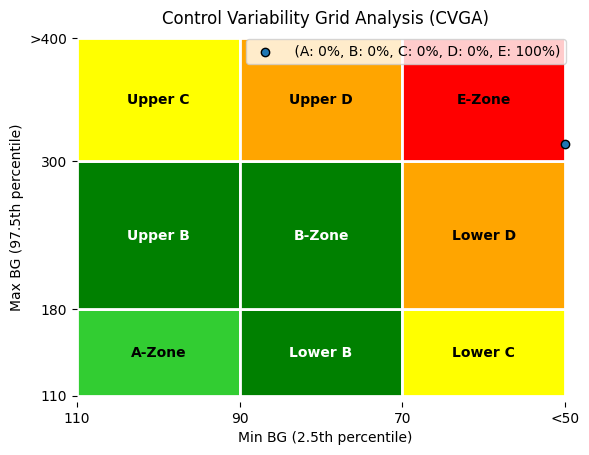

,70<=BG<=180,BG>180,BG<70,BG>250,BG<50,LBGI,HBGI,Risk Index
adult#002,54.83647,33.705993,11.457538,9.249358,7.520311,10.715387,7.204277,17.919665


In [ ]:
simulate(sim_time=my_sim_time,
         scenario=my_scenario,
         controller=my_controller,
         start_time=my_start_time,
         save_path='/content/results/my_results1',
         animate=False,
         parallel=False,
         patient_names=['adult#002'], #use comma if multiples
         cgm_name=my_sensor,
         cgm_seed=42,
         insulin_pump_name=my_pump)

#BR=0.03716742133742074, IC=0.007744750085899176.